In [250]:
import torch
import gpytorch
import numpy as np
import optuna
from src.plotting import plot_gp, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [251]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 8
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 11 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



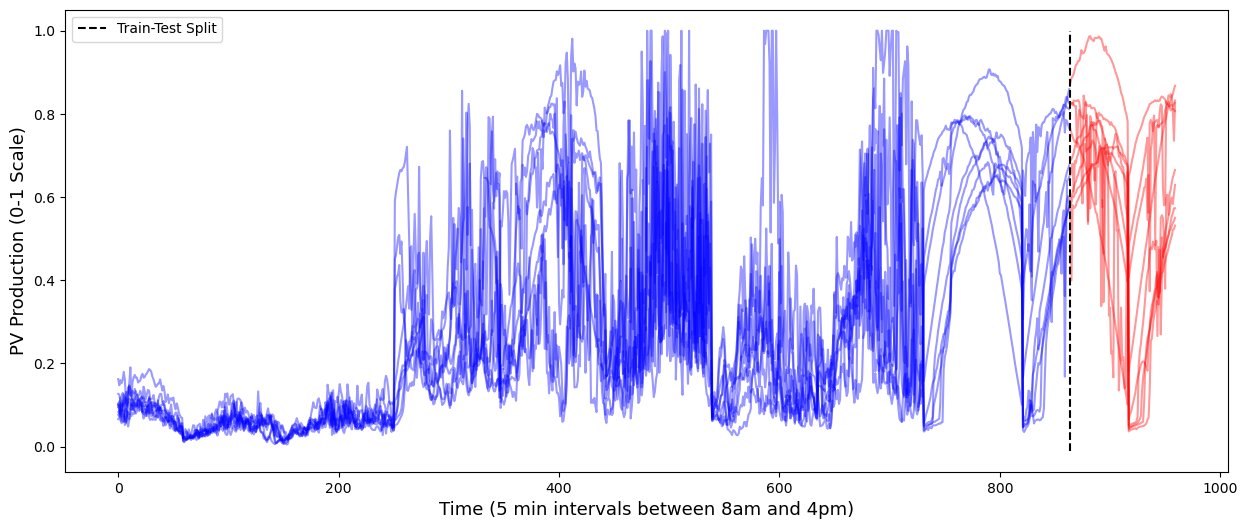

In [252]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
y = torch.clamp(y, min=1e-6, max=1)
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
time = torch.stack([time, periodic_time], dim=-1)

# scale time at 0 dim to [0, 1]
time[:, 0] = time[:,0] / time[:, 0].max()

x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [253]:
num_latents = 5
num_tasks = y_train.size(-1)
x_train = x_train.repeat(num_latents, 1, 1)
print(x_train.shape)

torch.Size([5, 864, 2])


In [254]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel)

matern_base = MaternKernel(nu=3/2, 
                      batch_shape=torch.Size([num_latents]),
                    # lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                    # lengthscale_constraint=gpytorch.constraints.Positive()
                    )
periodic = PeriodicKernel(  
                    # period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                    # period_length_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_periodic = ScaleKernel(
                    periodic,
                    # outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                    # outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_matern = ScaleKernel(matern_base, 
                    outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Interval(0.01, 1),
                    batch_shape=torch.Size([num_latents])
                    )
matern_periodic = ScaleKernel(periodic * matern_base,
                    outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )

quasi_periodic_matern = AdditiveKernel(matern_periodic, scaled_matern)

In [255]:
from gpytorch.variational import MeanFieldVariationalDistribution

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        
        # MeanField constructs a variational distribution for each output dimension
        variational_distribution = MeanFieldVariationalDistribution(
            x_train.size(-2), batch_shape=torch.Size([num_latents]),jitter=1e-2
        )
        
        # LMC constructs MultitaskMultivariateNormal from the base var dist
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, x_train, variational_distribution, learn_inducing_locations=False, jitter_val=1e-2
            ),
            num_tasks=y_train.size(-1),
            num_latents=num_latents,
            latent_dim=-1
        )
        
        super().__init__(variational_strategy)
        
        # batch for different hypers for each output dimension
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
        self.covar_module =  quasi_periodic_matern
        
    def forward(self, x):
    
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
      
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()
likelihood1 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y_train.size(-1))
likelihood2 = BetaLikelihood_MeanParametrization(
                scale=15,
                scale_prior=gpytorch.priors.GammaPrior(30, 2),
                scale_constraint=gpytorch.constraints.Interval(10, 25))

In [256]:
likelihood = likelihood1

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# SVI training loop for minimizing ELBO E_q(f) [log p(y|f)] - KL[q(f) || p(f)]
# where q(f) is the variational distribution and p(f) is the prior

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

n_iter = 300
print_freq = n_iter // 10

for i in range(n_iter + 1):
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train).mean()
    loss.backward()
    optimizer.step()

    if i % print_freq == 0:
        print('Iter %d/%d - Loss: %.3f' % (i, n_iter, loss.item()))

Iter 0/300 - Loss: 30.614
Iter 30/300 - Loss: 11.699
Iter 60/300 - Loss: 6.519
Iter 90/300 - Loss: 0.111
Iter 120/300 - Loss: -2.926
Iter 150/300 - Loss: -3.947
Iter 180/300 - Loss: -3.923
Iter 210/300 - Loss: -4.998
Iter 240/300 - Loss: -4.504
Iter 270/300 - Loss: -5.551
Iter 300/300 - Loss: -4.950


In [257]:
def get_predictions(model, likelihood, x):
    
    if isinstance(likelihood, gpytorch.likelihoods.MultitaskGaussianLikelihood):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            dist_train = likelihood(model(x))
            mean_train = dist_train.mean
            lower_train, upper_train = dist_train.confidence_region()

            return mean_train, lower_train, upper_train
    
    elif isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.num_likelihood_samples(40):
            dist_train = likelihood(model(x))
            modes_train = likelihood.mode()
            mean_train = modes_train.mean(axis=0)
            lower_train, upper_train = np.quantile(modes_train, q=[0.05, 0.95], axis=0)

            return mean_train, lower_train, upper_train


In [258]:
pred_train, lower_train, upper_train = get_predictions(model, likelihood, x_train)
pred_test, lower_test, upper_test = get_predictions(model, likelihood, x_test)

In [259]:
time_train = torch.arange(0, len(y_train))
time_test = torch.arange(len(y_train), len(y_train) + len(y_test))
t = torch.arange(len(y))

<Figure size 1500x1000 with 0 Axes>

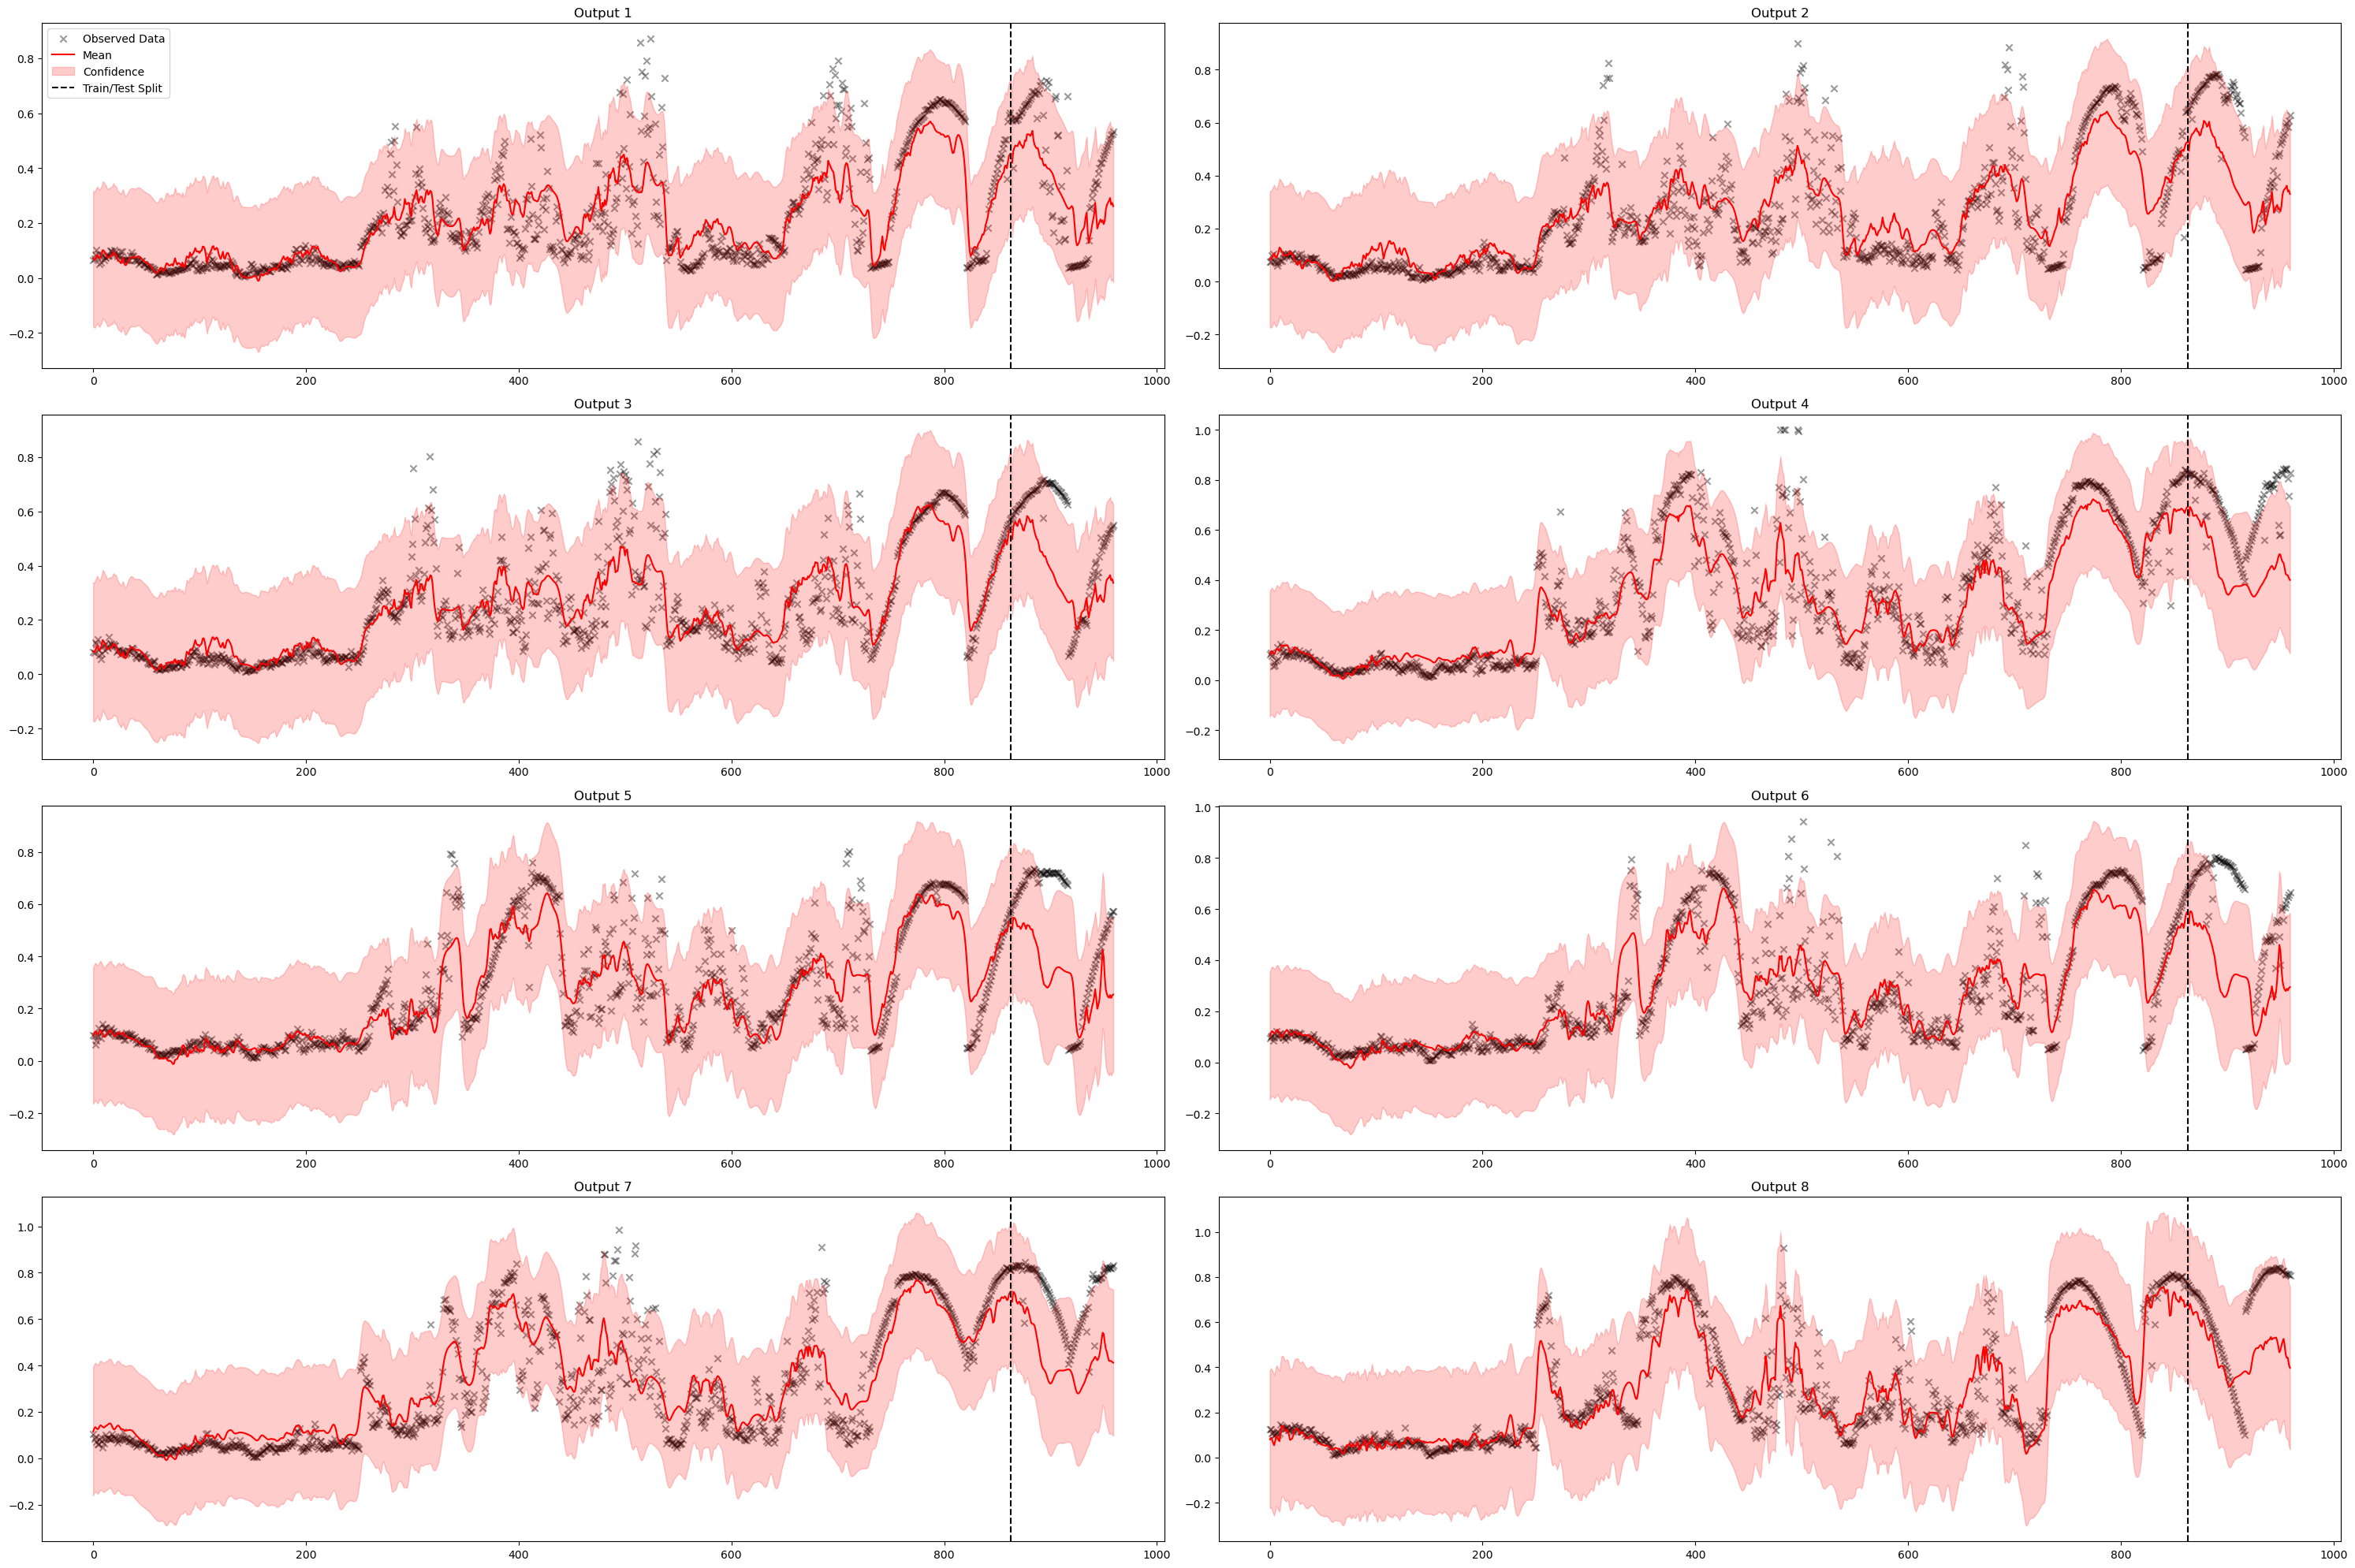

In [263]:
plt.figure(figsize=(15, 10))

fig, axs = plt.subplots(num_tasks//2, 2, figsize=(30, 20))
axs = axs.flatten()

for i in range(num_tasks - 1):
    
    axs[i].scatter(t, y[:, i], label='Observed Data', marker='x', color='k', alpha=0.4)
    
    axs[i].plot(time_train, pred_train[:, i], 'r', label='Mean')
    axs[i].plot(time_test, pred_test[:, i], 'r')
    
    axs[i].fill_between(time_train, lower_train[:, i], upper_train[:, i], alpha=0.2, label='Confidence', color='r')
    axs[i].fill_between(time_test, lower_test[:, i], upper_test[:, i], alpha=0.2, color='r')

    axs[i].axvline(x=time_train.max(), color='k', linestyle='--', label='Train/Test Split')


    axs[i].set_title(f'Output {i+1}')
    
    
    if i == 0:
        axs[i].legend(loc='upper left')

plt.tight_layout()
plt.show();